In [1]:
import kagglehub
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2


## 1️⃣ Choose a Dataset (Animal dataset) ✅


In [2]:
# Download latest version
dataset_path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", dataset_path)

Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


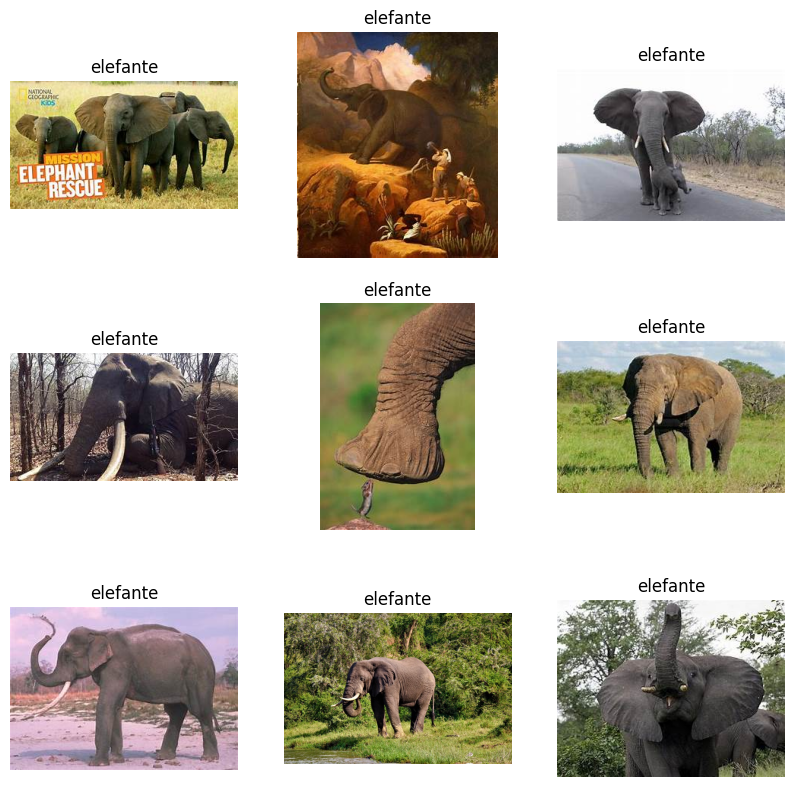

In [3]:
image_folder = os.path.join(dataset_path, "raw-img")

class_name = os.listdir(image_folder)[4]
class_path = os.path.join(image_folder, class_name)


image_files = os.listdir(class_path)[:9]

plt.figure(figsize=(10, 10))
for i, img_file in enumerate(image_files):
    img_path = os.path.join(class_path, img_file)
    img = Image.open(img_path)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_name)

plt.show()

# 2️⃣ Preprocess the data
1.   Resize Images to a Standard Shape
2.   Normalize Pixel Values
3.   Convert Labels to One-Hot Encoding
4.   Split Data into Train and Test Sets



In [4]:
image_paths = []  # List to store full paths of all images
labels = []       # List to store numeric labels corresponding to each image
classes = []      # List to store class names (folder names)

dataset_path = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img"

# Get the names of all folders inside the dataset directory (each folder represents a class)
classes = os.listdir(dataset_path)

# Iterate through all class folders in the dataset path
for label, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_path, class_name)

    # Iterate through all images inside the class folder
    for image_file in os.listdir(class_folder):
        image_paths.append(os.path.join(class_folder, image_file))
        labels.append(label)

# Read one image to know it is shape
sample_image = cv2.imread(image_paths[3]) # deferent shapes for deferent images so we need resize it
height, width, channels = sample_image.shape

print(f"Number of images: {len(image_paths)}")
print(f"Image size: {height}x{width}, Channels: {channels}")

Number of images: 26179
Image size: 205x300, Channels: 3


In [5]:
# 1. Load dataset filenames and labels

classes = [c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))]  # Filter only directories

all_filenames = []
all_labels = []

for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    filenames = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files
    all_filenames.extend([os.path.join(class_name, fname) for fname in filenames])
    all_labels.extend([class_name] * len(filenames))  # Keep class as a string

# 2. Split filenames into train and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    all_filenames, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# 3. Create ImageDataGenerator with Augmentations for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Normalize validation images

# 4. Create DataFrames for Train and Validation
train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_files, 'class': val_labels})

# 5. Create Data Generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=dataset_path,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=dataset_path,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 20943 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.


# 3️⃣  Build the first model (CNN)

Start with a CNN-based architecture, similar to what we did in yesterday’s lab.

You are free to experiment with different architectures, stacking layers (types & numbers), and hyperparameters.

### 💠 CNN-based architecture

In [6]:
# Create the model
CNN_model = Sequential()

# Convolutional layer with 32 filters, each of size (3, 3), and ReLU activation
CNN_model.add(Conv2D(32,(3,3), activation = 'relu', input_shape = (224,224,3)))

# Max pooling layer with pool size (2, 2)
CNN_model.add(MaxPooling2D((2,2)))

# Flatten the output
CNN_model.add(Flatten())

# Dense layer with 100 units and ReLU activation
CNN_model.add(Dense(100, activation = 'relu'))

# Classification layer with softmax activation
CNN_model.add(Dense(10, activation = 'softmax')) # 10 classes


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 394272)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │      39,427,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,429,206 (150.41 MB)

 Trainable params: 39,429,206 (150.41 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:

CNN_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = SGD(learning_rate=0.0001),
    metrics = ['accuracy']
)

history = CNN_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 242s 364ms/step - accuracy: 0.1940 - loss: 2.2082 - val_accuracy: 0.2124 - val_loss: 2.1591
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 221s 338ms/step - accuracy: 0.2127 - loss: 2.1600 - val_accuracy: 0.2376 - val_loss: 2.1233
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 223s 340ms/step - accuracy: 0.2296 - loss: 2.1358 - val_accuracy: 0.2351 - val_loss: 2.0981
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 222s 339ms/step - accuracy: 0.2438 - loss: 2.1115 - val_accuracy: 0.2498 - val_loss: 2.0750
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 226s 345ms/step - accuracy: 0.2547 - loss: 2.0973 - val_accuracy: 0.2832 - val_loss: 2.0523
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 223s 340ms/step - accuracy: 0.2617 - loss: 2.0833 - val_accuracy: 0.3107 - val_loss: 2.0420
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 227s 346ms/step - accuracy: 0.2705 - loss: 2.0680 - val_accuracy: 0.3071 - val_loss: 2.0144
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 223s 340ms/step - accuracy: 0.2767 -

### 💠VGG16 CNN architeture

In [9]:
# Create the model
VGG16 = Sequential()

# Block 1
VGG16.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(224,224,3)))
VGG16.add(BatchNormalization())
VGG16.add(Conv2D(64, (3,3), padding='same', activation='relu'))
VGG16.add(MaxPooling2D((2,2)))

# Block 2
VGG16.add(Conv2D(128, (3,3), padding='same', activation='relu'))
VGG16.add(BatchNormalization())
VGG16.add(Conv2D(128, (3,3), padding='same', activation='relu'))
VGG16.add(MaxPooling2D((2,2)))

# Block 3
VGG16.add(Conv2D(256, (3,3), padding='same', activation='relu'))
VGG16.add(BatchNormalization())
VGG16.add(Conv2D(256, (3,3), padding='same', activation='relu'))
VGG16.add(MaxPooling2D((2,2)))

# Block 4
VGG16.add(Conv2D(512, (3,3), padding='same', activation='relu'))
VGG16.add(BatchNormalization())
VGG16.add(Conv2D(512, (3,3), padding='same', activation='relu'))
VGG16.add(MaxPooling2D((2,2)))

# Block 5
VGG16.add(Conv2D(512, (3,3), padding='same', activation='relu'))
VGG16.add(BatchNormalization())
VGG16.add(Conv2D(512, (3,3), padding='same', activation='relu'))
VGG16.add(MaxPooling2D((2,2)))

# Flatten layer
VGG16.add(Flatten())

# Fully Connected layer 1
VGG16.add(Dense(2048 , activation='relu'))
VGG16.add(Dropout(0.5))  # Dropout to reduce overfitting


# Fully Connected layer 2
VGG16.add(Dense(2048 , activation='relu'))
VGG16.add(Dropout(0.5))  # Dropout to reduce overfitting

# Output layer
VGG16.add(Dense(10, activation='softmax'))  # 10 classes


In [10]:
VGG16.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,8

 Total params: 65,009,994 (247.99 MB)

 Trainable params: 65,007,050 (247.98 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [11]:

VGG16.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate= 0.0001 ),
    metrics = ['accuracy']
)

history = VGG16.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 372s 497ms/step - accuracy: 0.2219 - loss: 2.7406 - val_accuracy: 0.4057 - val_loss: 1.7218
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 281s 429ms/step - accuracy: 0.3559 - loss: 1.8672 - val_accuracy: 0.4343 - val_loss: 1.6930
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 281s 428ms/step - accuracy: 0.4096 - loss: 1.7267 - val_accuracy: 0.3995 - val_loss: 1.6695
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 281s 428ms/step - accuracy: 0.4650 - loss: 1.5545 - val_accuracy: 0.4947 - val_loss: 1.4242
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 281s 428ms/step - accuracy: 0.5106 - loss: 1.4147 - val_accuracy: 0.4108 - val_loss: 1.6482
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 281s 428ms/step - accuracy: 0.5825 - loss: 1.2253 - val_accuracy: 0.6610 - val_loss: 1.0074
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 280s 428ms/step - accuracy: 0.6446 - loss: 1.0615 - val_accuracy: 0.6037 - val_loss: 1.2696
Epoch 8/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 281s 428ms/step - accuracy: 0.6873 -

###💠 LeNet-5 CNN architeture

In [18]:
LeNet_5 = Sequential()

# First Convolutional Layer
LeNet_5.add(Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(224,224,3)))
LeNet_5.add(BatchNormalization())  # Improves stability
LeNet_5.add(MaxPooling2D((2,2)))

# Second Convolutional Layer
LeNet_5.add(Conv2D(64, (5,5), activation='relu', padding='same'))
LeNet_5.add(BatchNormalization())
LeNet_5.add(MaxPooling2D((2,2)))

# Third Convolutional Layer
LeNet_5.add(Conv2D(128, (3,3), activation='relu', padding='same'))
LeNet_5.add(BatchNormalization())

# Flatten the output
LeNet_5.add(Flatten())

# Fully Connected Layer 1
LeNet_5.add(Dense(256, activation='relu'))
LeNet_5.add(Dropout(0.5))  # Prevent overfitting

# Fully Connected Layer 2
LeNet_5.add(Dense(128, activation='relu'))
LeNet_5.add(Dropout(0.5))

# Output Layer
LeNet_5.add(Dense(10, activation='softmax'))  # Assuming 10 classes

In [19]:
LeNet_5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 224, 224, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 112, 112, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │     102,760,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,923,338 (392.62 MB)

 Trainable params: 102,922,890 (392.62 MB)

 Non-trainable params: 448 (1.75 KB)

In [31]:
# Compile the model
LeNet_5.compile(
loss="categorical_crossentropy",
optimizer= Adam(learning_rate=0.001),
metrics=["accuracy"]
)

# Train the model
history_LeNet_5 = LeNet_5.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 231s 344ms/step - accuracy: 0.1802 - loss: 2.7789 - val_accuracy: 0.1841 - val_loss: 2.2082
Epoch 2/30
359/655 ━━━━━━━━━━━━━━━━━━━━ 1:35 324ms/step - accuracy: 0.1891 - loss: 2.1998

KeyboardInterrupt: 

### 💠 AlexNet CNN architeture

In [15]:
AlexNet = Sequential()

# Block 1
AlexNet.add(Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)))
AlexNet.add(BatchNormalization()) # Improve learning stability
AlexNet.add(MaxPooling2D((3, 3), strides=2))

# Block 2
AlexNet.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D((3, 3), strides=2))

# Block 3
AlexNet.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
AlexNet.add(BatchNormalization())
AlexNet.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
AlexNet.add(BatchNormalization())
AlexNet.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D((3, 3), strides=2))

# Flatten layer
AlexNet.add(Flatten())

# Fully Connected layer 1
AlexNet.add(Dense(4096, activation='relu'))
AlexNet.add(Dropout(0.5))

# Fully Connected layer 2
AlexNet.add(Dense(4096, activation='relu'))
AlexNet.add(Dropout(0.5))

# Output layer
AlexNet.add(Dense(10, activation='softmax'))  # 10 classes

In [16]:
AlexNet.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 54, 54, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 26, 26, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 12, 12, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 12, 12, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4096)                │      26,218,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │          40,9

 Total params: 46,793,482 (178.50 MB)

 Trainable params: 46,790,730 (178.49 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [17]:
# Compile the model
AlexNet.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

AlexNet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 241s 351ms/step - accuracy: 0.1864 - loss: 6.6233 - val_accuracy: 0.2393 - val_loss: 2.1781
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 223s 340ms/step - accuracy: 0.2492 - loss: 2.1834 - val_accuracy: 0.1600 - val_loss: 2.2929
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 221s 337ms/step - accuracy: 0.2678 - loss: 2.1146 - val_accuracy: 0.2639 - val_loss: 2.1239
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 219s 335ms/step - accuracy: 0.2821 - loss: 2.0767 - val_accuracy: 0.2523 - val_loss: 2.0527
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 220s 336ms/step - accuracy: 0.3078 - loss: 2.0175 - val_accuracy: 0.2867 - val_loss: 2.0288
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 222s 338ms/step - accuracy: 0.3332 - loss: 1.9277 - val_accuracy: 0.3426 - val_loss: 1.8374
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 220s 336ms/step - accuracy: 0.3612 - loss: 1.8616 - val_accuracy: 0.3155 - val_loss: 1.9542
Epoch 8/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 221s 338ms/step - accuracy: 0.3986 -

# 4️⃣  Evaluate the models on the test set.

Report metrics: accuracy, precision, recall, and F1-score.

Visualize the confusion matrix to analyze performance across different classes.

Evaluating Model: CNN Model
--------------------------------------------------
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step
Accuracy: 0.1455
Precision: 0.1292
Recall: 0.0985
F1 Score: 0.0869

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.25      0.21       973
           1       0.09      0.09      0.09       525
           2       0.33      0.00      0.01       289
           3       0.07      0.06      0.06       422
           4       0.13      0.19      0.15       620
           5       0.17      0.01      0.03       334
           6       0.05      0.05      0.05       373
           7       0.08      0.03      0.04       364
           8       0.18      0.31      0.23       964
           9       0.00      0.00      0.00       372

    accuracy                           0.15      5236
   macro avg       0.13      0.10      0.09      5236
weighted avg       0.14      0.15      0.12      5236



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

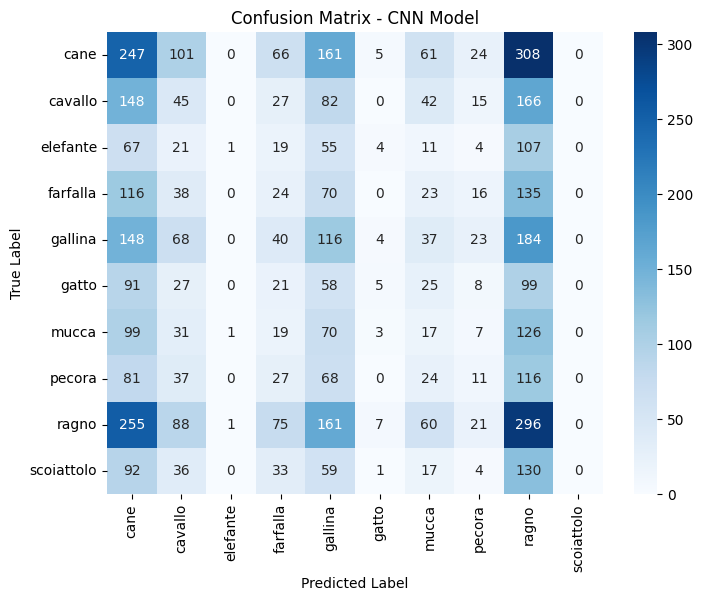

Evaluating Model: VGG16
--------------------------------------------------
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step
Accuracy: 0.1167
Precision: 0.0978
Recall: 0.0982
F1 Score: 0.0975

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.18      0.18       973
           1       0.08      0.06      0.07       525
           2       0.07      0.08      0.07       289
           3       0.07      0.10      0.09       422
           4       0.11      0.11      0.11       620
           5       0.06      0.08      0.07       334
           6       0.07      0.06      0.06       373
           7       0.08      0.07      0.08       364
           8       0.18      0.18      0.18       964
           9       0.07      0.06      0.06       372

    accuracy                           0.12      5236
   macro avg       0.10      0.10      0.10      5236
weighted avg       0.12      0.12      0.12      5236



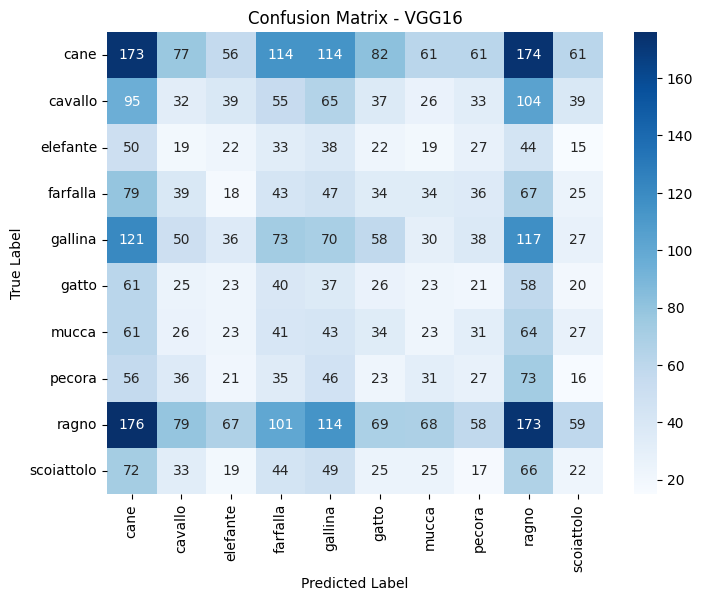

Evaluating Model: AlexNet
--------------------------------------------------
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step
Accuracy: 0.1280
Precision: 0.1052
Recall: 0.1041
F1 Score: 0.1040

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.22      0.21       973
           1       0.08      0.07      0.08       525
           2       0.08      0.07      0.08       289
           3       0.08      0.07      0.07       422
           4       0.11      0.11      0.11       620
           5       0.08      0.06      0.07       334
           6       0.07      0.06      0.07       373
           7       0.09      0.07      0.08       364
           8       0.17      0.20      0.19       964
           9       0.07      0.09      0.08       372

    accuracy                           0.13      5236
   macro avg       0.11      0.10      0.10      5236
weighted avg       0.12      0.13      0.13      5236



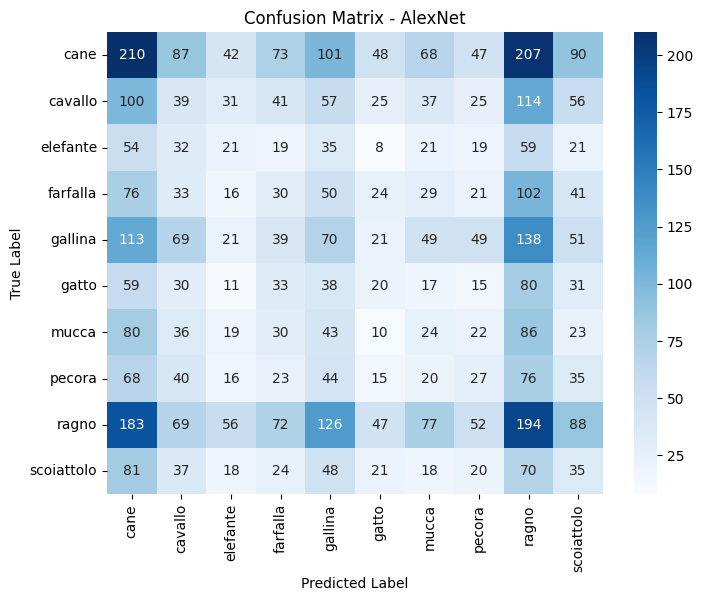

In [30]:

def evaluate_model(model, model_name, val_generator):
    print(f"Evaluating Model: {model_name}\n" + "-"*50)

    # Predict the labels from the validation data
    y_pred = model.predict(val_generator, verbose=1)  # Predict using the validation generator
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

    # Get true labels from the generator
    y_true_classes = val_generator.classes  # True class labels from the validation generator

    # Compute metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='macro')
    recall = recall_score(y_true_classes, y_pred_classes, average='macro')
    f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

    # Print evaluation results
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Print full classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes))

    # Plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


# Evaluate all models
#evaluate_model(CNN_model, "CNN Model", val_generator)
#evaluate_model(VGG16, "VGG16", val_generator)
evaluate_model(LeNet_5, "LeNet-5", val_generator)
#evaluate_model(AlexNet, "AlexNet", val_generator)


# 5️⃣ Save the Best Model

Store the best model on hard drive or google drive

In [25]:
from google.colab import drive
drive.mount('/content/drive')

VGG16.save('/content/drive/MyDrive/VGG16.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 6️⃣ Build the Second Model (Transfer Learning)
Use pre-trained models (EfficientNetB0, InceptionV3, ResNet-50).

In [ ]:
def load_data(data_dir, img_size=(224, 224), batch_size=32):
    train_ds = keras.preprocessing.image_dataset_from_directory(
        data_dir, validation_split=0.2, subset="training", seed=123,
        image_size=img_size, batch_size=batch_size)

    test_ds = keras.preprocessing.image_dataset_from_directory(
        data_dir, validation_split=0.2, subset="validation", seed=123,
        image_size=img_size, batch_size=batch_size)

    class_names = train_ds.class_names
    return train_ds, test_ds, len(class_names)

def build_model(model_name, num_classes):
    if model_name == 'resnet':
        base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'efficientnet':
        base_model = keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'inception':
        base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError("Model not supported")

    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_ds, val_ds, num_epochs= 50):
    history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs)
    return history

train_ds, val_ds, num_classes = load_data(dataset_path)
print("Class names from dataset:", train_ds.class_names)

In [ ]:
resnet_model = build_model("resnet", num_classes)
train_model(resnet_model, train_ds, val_ds)
print("=" * 100)
efficientnet_model = build_model("efficientnet", num_classes)
train_model(efficientnet_model, train_ds, val_ds)
print("=" * 100)
inception_model = build_model("inception", num_classes)
train_model(inception_model, train_ds, val_ds)

# 7️⃣ Evaluate the transfer learning models and Save the best-performing model.

In [ ]:
def evaluate_model(model, model_name, test_ds):
    print(f"Evaluating Model: {model_name}\n" + "-"*50)

    # Get true labels and images
    y_true = []
    X_test = []

    for images, labels in test_ds:
        X_test.append(images.numpy())  # Convert images to numpy array
        y_true.append(labels.numpy())  # Convert labels to numpy array

    X_test = np.concatenate(X_test, axis=0)
    y_true = np.concatenate(y_true, axis=0)

    # Predict the labels
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='macro')
    recall = recall_score(y_true, y_pred_classes, average='macro')
    f1 = f1_score(y_true, y_pred_classes, average='macro')

    # Print evaluation results
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Print full classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(np.unique(y_true))), yticklabels=range(len(np.unique(y_true))))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [ ]:
# Evaluate all models
evaluate_model(resnet_model,  "resnet model", val_ds)
evaluate_model(efficientnet_model, "efficientnet model", val_ds)
evaluate_model(inception_model, "inception model", val_ds)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

efficientnet_model.save('/content/drive/MyDrive/efficientnet_model.h5')

# 8️⃣ Compare & Choose the Best Model
Compare between the model from step 5 and the one from step 7.